In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
#Directories
this_dir = os.getcwd()
SECRETO_dir = this_dir[:-23] + 'SECRETO/'

Ib_dir = SECRETO_dir + 'WISEREP_Ib/Ib_tracks/'
Ic_dir = SECRETO_dir + 'WISEREP_Ic/Ic_tracks/'
IIb_dir = SECRETO_dir + 'WISEREP_IIb/IIb_tracks/'
dir_list = [IIb_dir, Ib_dir, Ic_dir]
model_tracks_dir = this_dir[:-5] + 'analysis/model_tracks/'

In [3]:
#Read in the model data and define the names of the SN
string_masses = np.array(['3p30', '4p00', '5p00', '6p00', '8p00']) #Write as 'xpxx'
version_name = 'v2p0'
tracks_arrays = []
for i in range(len(string_masses)):
    track = np.loadtxt(model_tracks_dir + 'NII_track_he_' + string_masses[i] + '_' + version_name + '.csv',
              delimiter = ',')
    tracks_arrays.append(track)

/tmp/ipykernel_4137/1321960654.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap =  plt.cm.get_cmap('nipy_spectral') #plt.cm.nipy_spectral


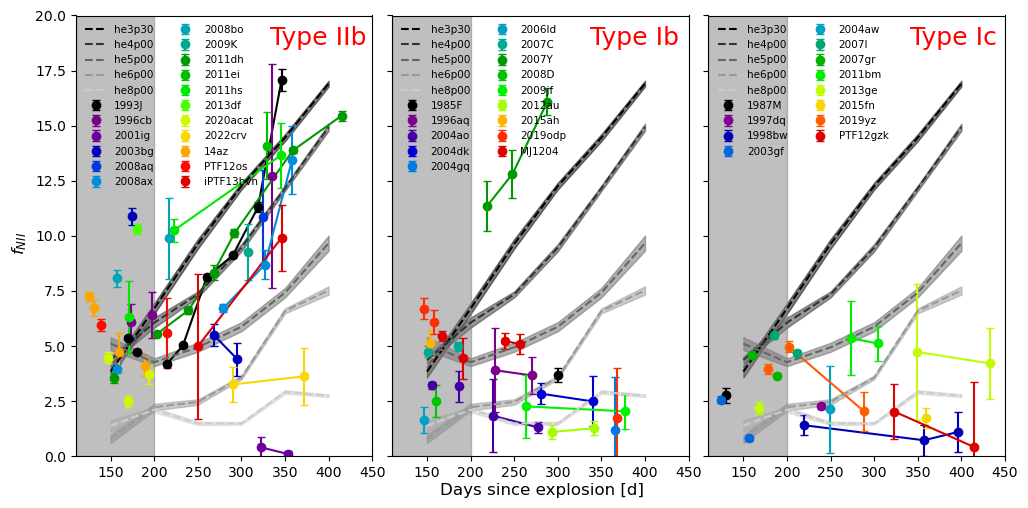

In [45]:
#Make the plot

fig, ax = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (10, 5))

#For each type, make the subplot
for i in range(3):
    
    observed_fnames = sorted(os.listdir(dir_list[i]))[1:] #There will always be a ipynb checkpoints in the dir
    
    colormap =  plt.cm.get_cmap('nipy_spectral') #plt.cm.nipy_spectral
    colors = colormap(np.linspace(0, 0.9, len(observed_fnames)))
    ax[i].set_prop_cycle('color', colors)

    #First we plot the observations per type
    for k in range(len(observed_fnames)):
        fname = observed_fnames[k]
        this_track = np.loadtxt(dir_list[i] + fname, delimiter = ',')
        try:
            epochs, NII_fluxes, NII_sigs = this_track[:, 0], this_track[:, 1], this_track[:, 2]
        except:
            epochs, NII_fluxes, NII_sigs = this_track[0], this_track[1], this_track[2]
            
        sn_name = fname[10:-4]
        
        #This is simply for plotting purposes
        if sn_name == 'SNMASTEROTJ1204':
            sn_name = 'SNMJ1204'
        elif sn_name == 'SNASASSN14az':
            sn_name = 'SN14az'
        elif sn_name == 'SNPTF12os':
            sn_name = 'SNPTF12os'
        elif sn_name == 'iPTF13bvn':
            sn_name = 'SNiPTF13bvn'
        
        if '2015Q' in sn_name:
            continue
        else:
            
            #Before plotting, bin those epochs that are within a certain range
            binwidth = 25
            epoch_bins = np.arange(0, 500, binwidth)
            epochs_binned, NII_fluxes_binned, NII_sigs_binned = [], [], []
            for z in range(len(epoch_bins)-1):
                mask = (epochs <= epoch_bins[z+1]) * (epochs > epoch_bins[z])
                if len(epochs[mask]) > 0:
                    epochs_binned.append(np.mean(epochs[mask]))
                    NII_fluxes_binned.append( np.average(NII_fluxes[mask], weights = 1/ (NII_sigs[mask]**2) )  )
                    NII_sigs_binned.append( np.sqrt(1 / np.sum(1/ (NII_sigs[mask]**2) ) ) )
                    
            epochs_binned, NII_fluxes_binned, NII_sigs_binned = np.array(epochs_binned), np.array(NII_fluxes_binned), np.array(NII_sigs_binned)
            #And now set a different alpha for epochs before cutoff
            #cut_epoch = 200
            #alpha_arr = np.ones(len(epoch_bins)) * 0.3
            #alpha_arr[epoch_bins >= cut_epoch] = 1
            
            ax[i].plot(epochs_binned[epochs_binned >= 200], NII_fluxes_binned[epochs_binned >= 200], c = colors[k])
            ax[i].errorbar(epochs_binned, NII_fluxes_binned, NII_sigs_binned, label = sn_name[2:], fmt = '.', ms = 12, capsize = 3, c = colors[k])
      
            

    #Finally, plot in the models
    #model_colours = ['green', 'yellow', 'orange', 'red', 'blue']
    colormap = plt.cm.gray #plt.cm.get_cmap('tab20') 
    model_colours = colormap(np.linspace(0, 0.8, len(tracks_arrays)))
    ax[i].set_prop_cycle('color', colors)
    
    
    for p in range(len(tracks_arrays)):
        this_track = tracks_arrays[p]
        track_epochs, NII_percentages, NII_sigmas = this_track[:, 0], this_track[:, 1], this_track[:, 2]
        
        ax[i].plot(track_epochs, NII_percentages, linestyle = '--', c = model_colours[p], label = 'he' + string_masses[p])
        ax[i].fill_between(track_epochs, NII_percentages-NII_sigmas, NII_percentages+NII_sigmas, color = model_colours[p], alpha = 0.5)

    ax[i].legend(frameon = False, fontsize = 7.5, loc = 'upper left', ncols = 2)
    
    ax[i].fill_between([110, 200], 0, 20, color = 'gray', alpha = 0.5)
        
ax[0].set_xlim(110, 450)
ax[0].set_ylim(0, 20)

fig.tight_layout()

fig.text(0.42, 0.00, s = 'Days since explosion [d]', fontsize = 12)
fig.text(-0.01, 0.49, s = '$f_{NII}$', rotation = 90, fontsize = 12)

fig.text(0.25, 0.9, s = 'Type IIb', c = 'red', fontsize = 18)
fig.text(0.57, 0.9, s = 'Type Ib', c = 'red', fontsize = 18)
fig.text(0.89, 0.9, s = 'Type Ic', c = 'red', fontsize = 18)

plt.savefig('Figure_x_NII_Tracks_Per_Type.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()